This notebook finetunes the Qwen-2B-VL model for medical visual question answering on the MedVQA dataset

In [1]:
from datasets import load_dataset
from IPython.display import display
from tqdm import tqdm
import nltk
import evaluate

import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from qwen_vl_utils import process_vision_info

/home/triho/Data/miniconda3/envs/nlpmedvqa/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# !pip install -U -q git+https://github.com/huggingface/trl.git bitsandbytes peft qwen-vl-utils trackio

In [3]:
# pip install evaluate nltk rouge_score bert_score

## 1. Load and process dataset

In [2]:
# datasets = load_dataset("SonicNLP/medvqa_dataset")
# train_dataset, eval_dataset, test_dataset = load_dataset("SonicNLP/medvqa_dataset", split=['train[:10%]', 'validation[:10%]', 'test[:10%]'])
train_dataset, eval_dataset, test_dataset = load_dataset("SonicNLP/medvqa_dataset", split=['train', 'validation', 'test'])
print(train_dataset)
print(eval_dataset)
print(test_dataset)
# train_dataset = datasets['train']
# val_dataset = datasets['validation']
# test_dataset = datasets['test']

Dataset({
    features: ['id', 'image', 'question', 'answers'],
    num_rows: 12792
})
Dataset({
    features: ['id', 'image', 'question', 'answers'],
    num_rows: 2000
})
Dataset({
    features: ['id', 'image', 'question', 'answers'],
    num_rows: 500
})


In [4]:
system_message = """You are a Vision Language Model specialized in interpreting visual data from medical images.
Your task is to analyze the provided medical image and respond to queries with concise answers, usually a single word, number, or short phrase.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

def format_data(sample):
    return {
      "images": [sample["image"].resize((256, 256))],
      "messages": [
          {
              "role": "system",
              "content": [
                  {
                      "type": "text",
                      "text": system_message
                  }
              ],
          },
          {
              "role": "user",
              "content": [
                  {
                      "type": "image",
                      "image": sample["image"],
                  },
                  {
                      "type": "text",
                      "text": sample['question'],
                  }
              ],
          },
          {
              "role": "assistant",
              "content": [
                  {
                      "type": "text",
                      "text": sample["answers"][0]
                  }
              ],
          },
      ]
      }

In [5]:
train_dataset = [format_data(sample) for sample in tqdm(train_dataset, desc="Processing train")]
eval_dataset = [format_data(sample) for sample in tqdm(eval_dataset, desc="Processing eval")]
test_dataset = [format_data(sample) for sample in tqdm(test_dataset, desc="Processing test")]

Processing train:   1%|▌                                                                  | 103/12792 [00:00<01:06, 191.18it/s]

Processing test: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 193.31it/s]


[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a Vision Language Model specialized in interpreting visual data from medical images.\nYour task is to analyze the provided medical image and respond to queries with concise answers, usually a single word, number, or short phrase.\nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]}, {'role': 'user', 'content': [{'type': 'image', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x659 at 0x14F4A028C2B0>}, {'type': 'text', 'text': 'what kind of image is this?'}]}, {'role': 'assistant', 'content': [{'type': 'text', 'text': 'cta - ct angiography'}]}]


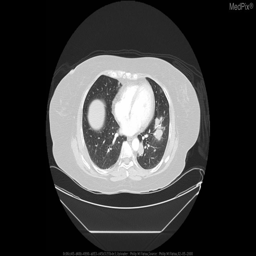

(256, 256)


In [6]:
sample = train_dataset[0]
print(sample['messages'])
display(sample['images'][0])
print(sample['images'][0].size)

### 2. Load the model and inspect original performance

In [ ]:
model_id = "Qwen/Qwen2-VL-2B-Instruct"
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

processor = Qwen2VLProcessor.from_pretrained(model_id)

`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.47it/s]
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


In [7]:
def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        # sample['messages'][1:2],  # Use the sample without the system message
        sample['messages'][:2],
        tokenize=False,
        add_generation_prompt=True
    )

    # Process the visual input from the sample
    image_inputs, _ = process_vision_info(sample['messages'])

    # Prepare the inputs for the model
    model_inputs = processor(
        text=[text_input],
        images=image_inputs,
        return_tensors="pt",
    ).to(device)  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

In [31]:
# Example of how to call the method with sample:
output = generate_text_from_sample(model, processor, train_dataset[0])
output

'CT scan'

### 3. Fine-tuning

In [44]:
import gc
import time

def clear_memory():
    # Delete variables if they exist in the current global scope
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'peft_model' in globals(): del globals()['peft_model']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

clear_memory()

GPU allocated memory: 2.03 GB
GPU reserved memory: 2.05 GB


Training

In [8]:
from transformers import BitsAndBytesConfig
import torch

model_id = "Qwen/Qwen2-VL-2B-Instruct"

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
processor = Qwen2VLProcessor.from_pretrained(model_id)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.43it/s]
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


In [ ]:
from peft import LoraConfig, get_peft_model

# Configure LoRA
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

trainable params: 1,089,536 || all params: 2,210,075,136 || trainable%: 0.0493


In [ ]:
from trl import SFTConfig

# Configure training arguments
training_args = SFTConfig(
    output_dir="qwen2-2b-MedVQA-2",  # Directory to save the model
    num_train_epochs=10,  # Number of training epochs
    per_device_train_batch_size=32,  # Batch size for training
    per_device_eval_batch_size=32,  # Batch size for evaluation
    gradient_accumulation_steps=4,  # Steps to accumulate gradients
    gradient_checkpointing_kwargs={"use_reentrant": False},  # Options for gradient checkpointing
    max_length=None,
    # Optimizer and scheduler settings
    optim="adamw_torch_fused",  # Optimizer type
    learning_rate=1e-5,  # Learning rate for training
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,  # Ratio of total steps for warmup
    # Logging and evaluation
    logging_steps=10,  # Steps interval for logging
    eval_strategy='epoch',  # Steps interval for evaluation
    save_strategy="epoch",  # Strategy for saving the model
    # Mixed precision and gradient settings
    bf16=True,  # Use bfloat16 precision
    max_grad_norm=0.3,  # Maximum norm for gradient clipping
    # Hub and reporting
    push_to_hub=True,  # Whether to push model to Hugging Face Hub
    report_to="wandb",  # Reporting tool for tracking metrics
)

In [11]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=peft_config,
    processing_class=processor,
)

/home/triho/Data/miniconda3/envs/nlpmedvqa/lib/python3.10/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/home/triho/Data/miniconda3/envs/nlpmedvqa/lib/python3.10/site-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [12]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.
wandb: Currently logged in as: htkhang0966 (htkhang0966-the-university-of-technology-sydney) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,3.990400,3.971650,4.097807,2221351.000000,0.486974
2,3.830000,3.830303,3.955291,4442702.000000,0.501375
3,3.812400,3.815667,3.931196,6664053.000000,0.502420
4,3.807200,3.809293,3.920729,8885404.000000,0.502903
5,3.807400,3.806549,3.918322,11106755.000000,0.503197
6,3.801700,3.804189,3.915318,13328106.000000,0.503438
7,3.802000,3.803164,3.912841,15549457.000000,0.503632
8,3.802000,3.802427,3.910927,17770808.000000,0.503558
9,3.799600,3.802254,3.911038,19992159.000000,0.503657
10,3.798600,3.802197,3.911001,22213510.000000,0.503664


TrainOutput(global_step=1000, training_loss=4.082292938232422, metrics={'train_runtime': 9985.9688, 'train_samples_per_second': 12.81, 'train_steps_per_second': 0.1, 'total_flos': 2.8064308831985664e+17, 'train_loss': 4.082292938232422, 'epoch': 10.0})

In [13]:
trainer.save_model(training_args.output_dir)

Processing Files (3 / 3): 100%|███████████████████████████████████████████████████████████████████| 15.8MB / 15.8MB,  0.00B/s  
New Data Upload: |                                                                                |  0.00B /  0.00B,  0.00B/s  
No files have been modified since last commit. Skipping to prevent empty commit.


In [ ]:
# %cd "/data/triho/NLP_VQA"
# %pip install wandb

In [ ]:
clear_memory()

### 4. Evaluate on test set

In [14]:
def generate_vlm_predictions(model, processor, dataset, num_samples=-1, device="cuda"):
    predictions = []
    references = []

    for sample in tqdm(dataset[:num_samples], desc="Generating VLM predictions"):
        pred = generate_text_from_sample(model, processor, sample, device=device)
        predictions.append(pred.strip())
        references.append(sample['messages'][-1]['content'][0]['text'].strip())
    
    return predictions, references

def compute_metrics(predictions, references):
    # Load evaluation metrics
    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    meteor = evaluate.load("meteor")
    bertscore = evaluate.load("bertscore")

    # --- ROUGE ---
    rouge_result = rouge.compute(predictions=predictions, references=references)

    # --- BLEU ---
    bleu_result = bleu.compute(predictions=predictions, references=references, max_order=2)

    # --- METEOR ---
    meteor_result = meteor.compute(predictions=predictions, references=references)

    # --- BERTScore---
    bert_result = bertscore.compute(predictions=predictions, references=references, lang="en")
    avg_bert_f1 = sum(bert_result["f1"]) / len(bert_result["f1"])

    return {
        "rouge1": rouge_result['rouge1'],
        'rouge2': rouge_result['rouge2'],
        'rougeL': rouge_result['rougeL'],
        "bleu": bleu_result['bleu'],
        "meteor": meteor_result['meteor'],
        "bertscore": avg_bert_f1,
    }

# predictions, references = generate_vlm_predictions(model, processor, test_dataset, device="cuda")
# eval_results = compute_metrics(predictions, references, use_bertscore=True)
# print(eval_results)

In [15]:
model_id = "Qwen/Qwen2-VL-2B-Instruct"
pretrained_model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

finetuned_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "/data/triho/NLP_VQA/qwen2-2b-MedVQA-2",
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

processor = Qwen2VLProcessor.from_pretrained(model_id)

Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.48it/s]


In [16]:
pretrained_predictions, references = generate_vlm_predictions(pretrained_model, processor, test_dataset, device="cuda")
finetuned_predictions, references = generate_vlm_predictions(finetuned_model, processor, test_dataset, device="cuda")

Generating VLM predictions: 100%|████████████████████████████████████████████████████████████| 499/499 [02:46<00:00,  2.99it/s]


In [17]:
pretrained_eval_results = compute_metrics(pretrained_predictions, references)
finetuned_eval_results = compute_metrics(finetuned_predictions, references)

[nltk_data] Downloading package wordnet to /home/triho/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/triho/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/triho/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[nltk_data] Downloading package wordnet to /home/triho/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/triho/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/triho/nltk_data...
[nltk_data]   Package omw-1.4 is already up

In [18]:
import pandas as pd
result_df = pd.DataFrame(columns=["Model"] + list(finetuned_eval_results.keys()))
result_df.loc[0] = {
    "Model": "Qwen2-VL-2B Pretrained",
    **pretrained_eval_results
}
result_df.loc[1] = {
    "Model": "Qwen2-VL-2B Finetuned",
    **finetuned_eval_results
}
result_df

,Model,rouge1,rouge2,rougeL,bleu,meteor,bertscore
0,Qwen2-VL-2B Pretrained,0.271953,0.000000,0.272483,0.00000,0.131504,0.876742
1,Qwen2-VL-2B Finetuned,0.413039,0.099332,0.413530,0.23805,0.259482,0.897806
